In [26]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [27]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import fits_to_pandas, pandas_to_fits
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import astropy.io.fits as fits
import healpy as hp
import nway_python_api as nway
%matplotlib inline

In [28]:
def match_cats(magnitude_columns=[]):

    ero_table = nway.table_from_fits(data_path+'ERO_lhpv_03_23_sd01_a15_g14.fits', )
    ero_random_table = nway.table_from_fits(data_path+'ERO_lhpv_03_23_sd01_a15_g14_shifted.fits',)

    desi_table = nway.table_from_fits(data_path+'desi_lh.fits', poserr_value=0.1, magnitude_columns=magnitude_columns)

    ero_pandas = fits_to_pandas('ERO_lhpv_03_23_sd01_a15_g14.fits')
    desi_pandas = fits_to_pandas('desi_lh.fits')




    nway_res_ero_orig = nway.nwaylib.nway_match(
    [ero_table, desi_table],
    match_radius = 20,
    prior_completeness = 1,
    mag_include_radius = 3.0,
    store_mag_hists = True
    )

    nway_res_ero_random_orig = nway.nwaylib.nway_match(
    [ero_random_table, desi_table],
    match_radius = 20,
    prior_completeness = 1,
    mag_include_radius = 3.0,
    store_mag_hists = True
    )


    nway_res_ero = nway_res_ero_orig
    nway_res_ero_random = nway_res_ero_random_orig

    nway_res_ero.sort_values(by=['EROSITA', 'prob_this_match' ], inplace=True, ascending=[True, False])
    nway_res_ero_random.sort_values(by=['EROSITA', 'prob_this_match' ], inplace=True, ascending=[True, False])

    cutoffs, nway_efficiency, nway_purity = nway.calibrate_cutoff(nway_res_ero, nway_res_ero_random)


    true_ctps = pd.read_pickle(data_path+'final_ctps_ero_csc_desi.pkl')


    nway_res_ero  = nway_res_ero.merge(ero_pandas, on='EROSITA')
    nway_res_ero  = nway_res_ero.merge(desi_pandas, on='DESI', suffixes=('_ero', '_desi'))

    nway_res_ero['true_ctps'] = False

    for desi_id, ero_id in zip(true_ctps['desi_id'], true_ctps['ID_ero']):
        id_tmp  = (nway_res_ero.desi_id == desi_id) & (nway_res_ero.ID==ero_id)
        #print(np.sum(id_tmp))
        nway_res_ero.loc[id_tmp, 'true_ctps'] = True


    completeness_validation = []
    purity_validation = []

    num_ctps = np.sum(nway_res_ero.true_ctps)
    cutoffs = np.linspace(0.01, 0.99, 100)
    for cutoff in tqdm(cutoffs):
        tp = len(nway_res_ero.query("true_ctps==True & match_flag==1 & prob_this_match>@cutoff"))
        fp = len(nway_res_ero.query("true_ctps==False & match_flag==1 & prob_this_match>@cutoff"))
        fn = len(nway_res_ero.query("true_ctps==True & match_flag==0 & prob_this_match>@cutoff"))
        tn = len(nway_res_ero.query("true_ctps==False & match_flag==0 & prob_this_match>@cutoff"))

        #completeness = tp/(tp+fp)
        completeness = tp / num_ctps
        completeness_validation.append(completeness)
        purity = tp/(tp+fn)
        purity_validation.append(purity)

    completeness_validation = np.array(completeness_validation)
    purity_validation = np.array(purity_validation)


    fig,  ax =  plt.subplots( figsize = (12,12))
    ax.plot(cutoffs, purity_validation, label = 'validation purity = [true positives]/[true positives + false negatives]')
    ax.plot(cutoffs, completeness_validation, label = 'validation completeness = [true positives]/[num of validation ctps]')


    sns.ecdfplot(nway_res_ero.prob_has_match, label = 'nway cumsum p_any', complementary=True, ax=ax)

    plt.ylim(0.5, 1.1)
    plt.xlabel('p_any cutoff')
    plt.ylabel('metric')
    plt.legend()
    
    return nway_res_ero, cutoffs, purity_validation, completeness_validation

    adding angular separation columns
matching:  78684 matches after filtering by search radius
Primary catalogue "EROSITA" (9500), density gives 2.13e+07 objects on entire sky
Catalogue "DESI" (2418574), density gives 2.39e+09 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 9500/9500 [00:02<00:00, 3445.27it/s]
Incorporating bias "DESI:nnprior" ...
magnitude histogramming: using user-supplied histogram for "DESI_nnprior"


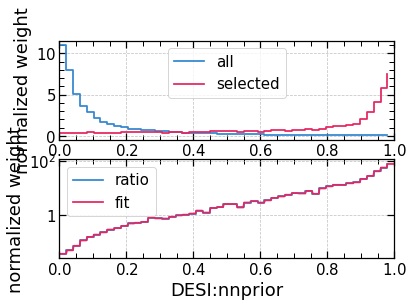

Incorporating bias "DESI:mag_g" ...
magnitude histogram of column "DESI_mag_g": 5674 secure matches, 5786 insecure matches and 2363973 secure non-matches of 2418574 total entries (2369647 valid)


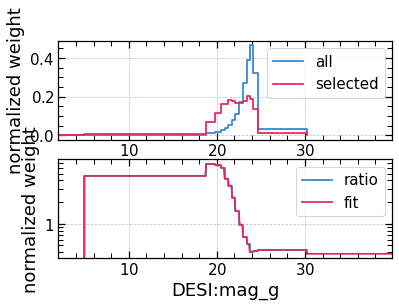

Incorporating bias "DESI:mag_r" ...
magnitude histogram of column "DESI_mag_r": 5720 secure matches, 5786 insecure matches and 2400070 secure non-matches of 2418574 total entries (2405790 valid)


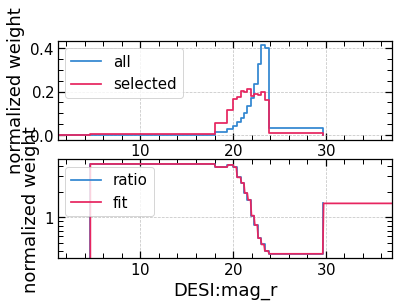

Incorporating bias "DESI:mag_z" ...
magnitude histogram of column "DESI_mag_z": 5738 secure matches, 5786 insecure matches and 2396707 secure non-matches of 2418574 total entries (2402445 valid)


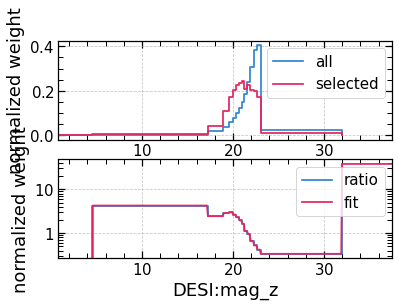

Incorporating bias "DESI:mag_w1" ...
magnitude histogram of column "DESI_mag_w1": 5499 secure matches, 5786 insecure matches and 2116709 secure non-matches of 2418574 total entries (2122208 valid)


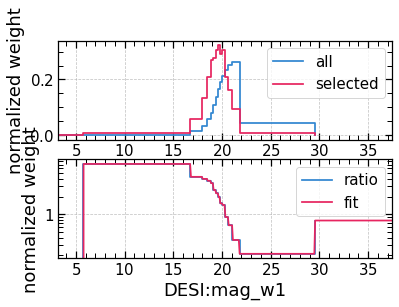

Incorporating bias "DESI:mag_w2" ...
magnitude histogram of column "DESI_mag_w2": 5349 secure matches, 5786 insecure matches and 1830100 secure non-matches of 2418574 total entries (1835449 valid)


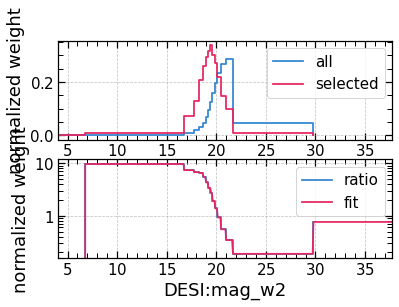

/Users/sdbykov/work/my_packages/nway/nwaylib/__init__.py:375: RuntimeWarning: divide by zero encountered in log10
  weights = log10(func(magcol))
Incorporating bias "DESI:col_gr" ...
magnitude histogram of column "DESI_col_gr": 5652 secure matches, 5786 insecure matches and 2356455 secure non-matches of 2418574 total entries (2362107 valid)


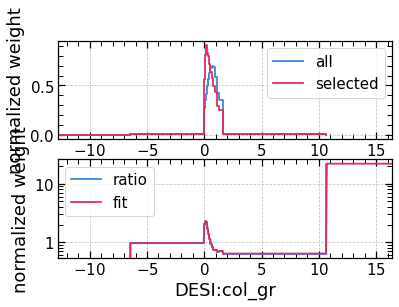

Incorporating bias "DESI:col_rz" ...
magnitude histogram of column "DESI_col_rz": 5699 secure matches, 5786 insecure matches and 2384981 secure non-matches of 2418574 total entries (2390680 valid)


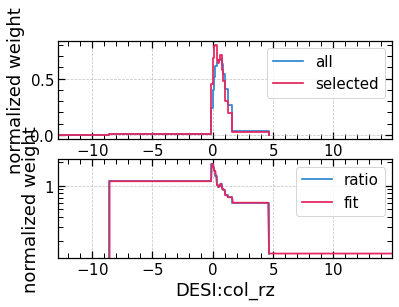

Incorporating bias "DESI:col_zw1" ...
magnitude histogram of column "DESI_col_zw1": 5487 secure matches, 5786 insecure matches and 2109808 secure non-matches of 2418574 total entries (2115295 valid)


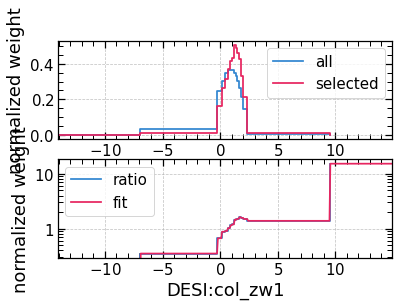

Incorporating bias "DESI:col_rw2" ...
magnitude histogram of column "DESI_col_rw2": 5316 secure matches, 5786 insecure matches and 1821384 secure non-matches of 2418574 total entries (1826700 valid)


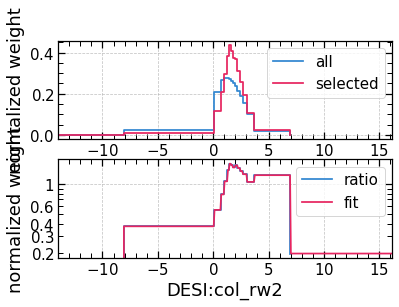


Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...
    adding angular separation columns
matching:  54727 matches after filtering by search radius
Primary catalogue "EROSITA" (8175), density gives 1.83e+07 objects on entire sky
Catalogue "DESI" (2418574), density gives 2.39e+09 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 8175/8175 [00:02<00:00, 3096.73it/s]
Incorporating bias "DESI:nnprior" ...
magnitude histogramming: using user-supplied histogram for "DESI_nnprior"


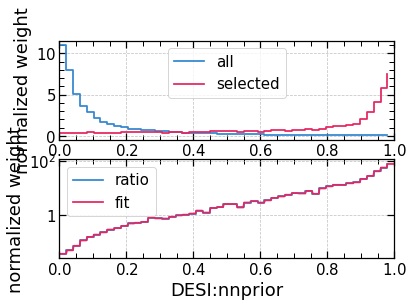

Incorporating bias "DESI:mag_g" ...
magnitude histogram of column "DESI_mag_g": 1045 secure matches, 1076 insecure matches and 2368602 secure non-matches of 2418574 total entries (2369647 valid)


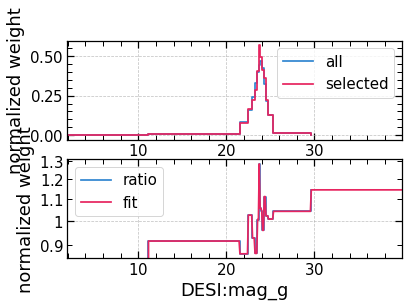

/Users/sdbykov/work/my_packages/nway/nwaylib/__init__.py:375: RuntimeWarning: divide by zero encountered in log10
  weights = log10(func(magcol))
Incorporating bias "DESI:mag_r" ...
magnitude histogram of column "DESI_mag_r": 1071 secure matches, 1076 insecure matches and 2404719 secure non-matches of 2418574 total entries (2405790 valid)


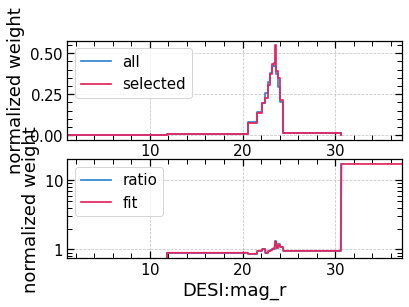

Incorporating bias "DESI:mag_z" ...
magnitude histogram of column "DESI_mag_z": 1069 secure matches, 1076 insecure matches and 2401376 secure non-matches of 2418574 total entries (2402445 valid)


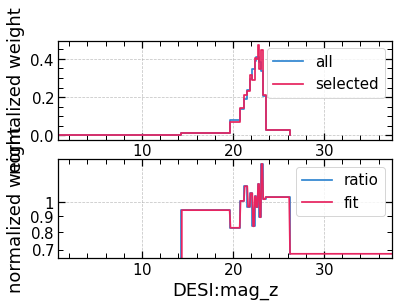

Incorporating bias "DESI:mag_w1" ...
magnitude histogram of column "DESI_mag_w1": 952 secure matches, 1076 insecure matches and 2121256 secure non-matches of 2418574 total entries (2122208 valid)


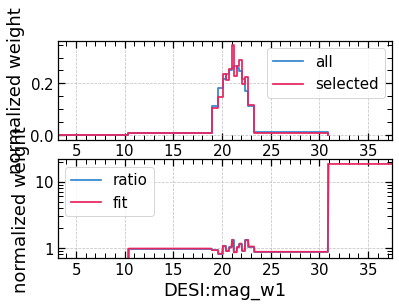

Incorporating bias "DESI:mag_w2" ...
magnitude histogram of column "DESI_mag_w2": 812 secure matches, 1076 insecure matches and 1834637 secure non-matches of 2418574 total entries (1835449 valid)


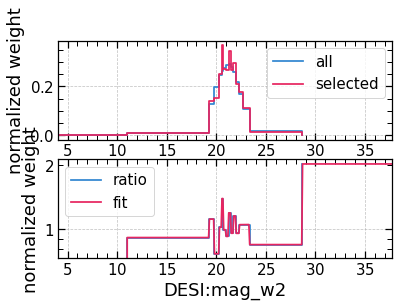

Incorporating bias "DESI:col_gr" ...
magnitude histogram of column "DESI_col_gr": 1042 secure matches, 1076 insecure matches and 2361065 secure non-matches of 2418574 total entries (2362107 valid)


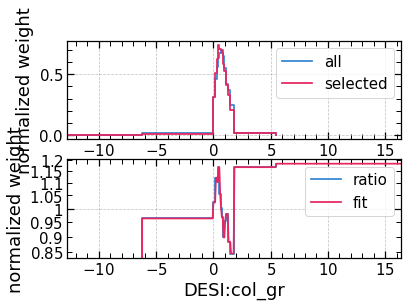

Incorporating bias "DESI:col_rz" ...
magnitude histogram of column "DESI_col_rz": 1064 secure matches, 1076 insecure matches and 2389616 secure non-matches of 2418574 total entries (2390680 valid)


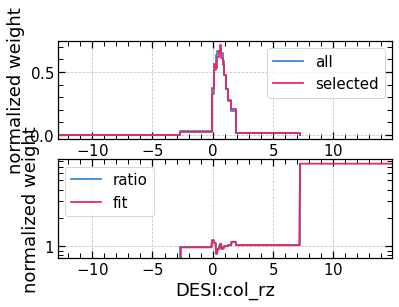

Incorporating bias "DESI:col_zw1" ...
magnitude histogram of column "DESI_col_zw1": 950 secure matches, 1076 insecure matches and 2114345 secure non-matches of 2418574 total entries (2115295 valid)


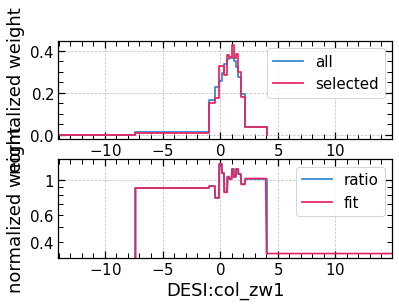

Incorporating bias "DESI:col_rw2" ...
magnitude histogram of column "DESI_col_rw2": 808 secure matches, 1076 insecure matches and 1825892 secure non-matches of 2418574 total entries (1826700 valid)


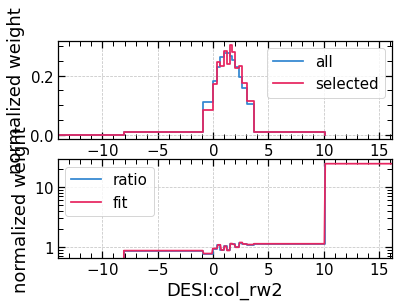


Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...
/Users/sdbykov/work/my_packages/nway/nwaylib/__init__.py:420: RuntimeWarning: invalid value encountered in subtract
  bfsum1 = log10((10**(values[1:] - offset)).sum()) + offset



For a false detection rate of <1%
--> use only counterparts with p_any>0.90 (70.89% of matches)

For a false detection rate of <3%
--> use only counterparts with p_any>0.80 (75.56% of matches)

For a false detection rate of <5%
--> use only counterparts with p_any>0.73 (77.64% of matches)

For a false detection rate of <10%
--> use only counterparts with p_any>0.61 (80.43% of matches)
The efficiency is 83.56%
The purity is  83.45%


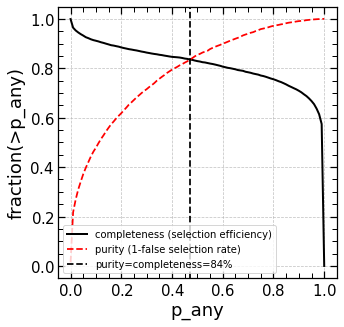

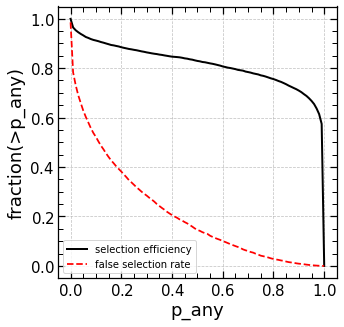

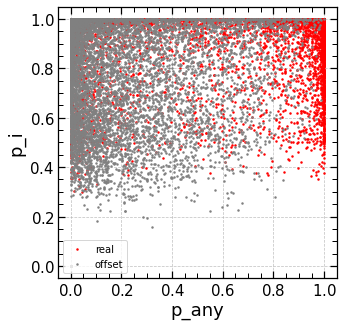

100%|██████████| 100/100 [00:01<00:00, 79.08it/s]


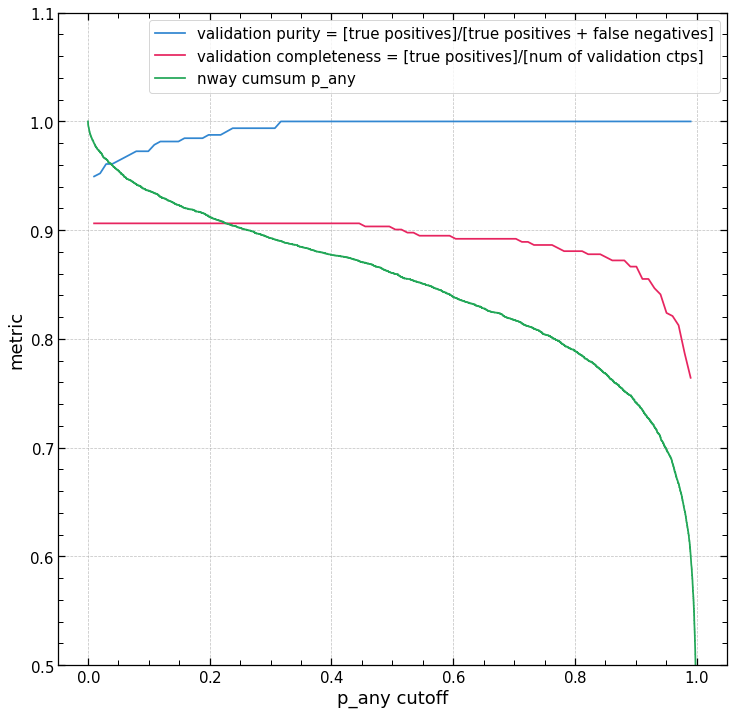

In [29]:

magnitude_columns = [('nnprior', '../1_csc-desi-photo-prior/model/nn-prior.csv'),
                    ('mag_g', 'auto'),
                    ('mag_r', 'auto'),
                    ('mag_z', 'auto'),
                    ('mag_w1', 'auto'),
                    ('mag_w2', 'auto'),
                    ('col_gr', 'auto'),
                    ('col_rz', 'auto'),
                    ('col_zw1', 'auto'),
                    ('col_rw2', 'auto')]

nway_res_ero, cutoffs, purity_validation, completeness_validation = match_cats(magnitude_columns)


In [69]:
inspect_cols = ['EROSITA', 'Separation_EROSITA_DESI','match_flag', 'prob_has_match', 'prob_this_match', 'dist_post', 'dist_bayesfactor', 'nnprior', 'ID', 'pos_err', 'desi_id', 'true_ctps']
df_inspect = nway_res_ero.query('true_ctps==1 & match_flag==0')[inspect_cols]
ids = df_inspect.ID
df_inspect

,EROSITA,Separation_EROSITA_DESI,match_flag,prob_has_match,prob_this_match,dist_post,dist_bayesfactor,nnprior,ID,pos_err,desi_id,true_ctps
18883,2375,0.712585,0,0.999722,0.021030,0.842443,10.106683,0.664017,b'SRGe J104901.2+572604',2.527204,b'9011_609948_2927',True
21971,2801,3.479986,0,0.999105,0.009723,0.603935,9.561804,0.616322,b'SRGe J104718.3+593247',3.995775,b'9011_615997_3610',True
21980,2802,2.888275,0,0.445628,0.026664,0.685549,9.717067,0.378808,b'SRGe J104530.6+555301',3.356547,b'9011_605186_839',True
22823,2917,1.954128,0,0.993498,0.064356,0.760464,9.880288,0.417329,b'SRGe J103604.4+574749',3.012458,b'9011_610717_53',True
35586,4688,4.723711,0,0.968006,0.002244,0.375923,9.158442,0.392539,b'SRGe J105555.9+571300',6.816140,b'9011_609172_759',True
39412,5221,2.234617,0,0.988127,0.193901,0.707641,9.762477,0.723128,b'SRGe J104342.6+585331',3.451890,b'9011_614515_1599',True
40024,5310,2.761430,0,0.432767,0.100925,0.577705,9.514671,0.396412,b'SRGe J103256.5+574818',4.673166,b'9011_610715_1094',True
41207,5479,2.314598,0,0.989396,0.005508,0.656466,9.659823,0.514189,b'SRGe J103452.0+581349',3.961392,b'9011_612249_3650',True
41766,5561,3.455432,0,0.999780,0.000003,0.545847,9.458450,0.122654,b'SRGe J105151.7+573908',4.772239,b'9011_610725_1881',True
41811,5568,1.864170,0,0.215470,0.099848,0.620673,9.592430,0.184048,b'SRGe J104654.5+585802',4.463631,b'9011_614517_505',True


In [70]:
#query nway_res_ero for all ids in df_inspect
nway_res_ero_bad_assign = nway_res_ero.query('ID in @ids')

In [71]:

nway_res_ero_bad_assign[nway_res_ero_bad_assign.EROSITA==9274][inspect_cols]
nway_res_ero_bad_assign[nway_res_ero_bad_assign.EROSITA==7530][inspect_cols]

,EROSITA,Separation_EROSITA_DESI,match_flag,prob_has_match,prob_this_match,dist_post,dist_bayesfactor,nnprior,ID,pos_err,desi_id,true_ctps
55632,7530,8.806883,1,0.993149,9.302660e-01,0.235460,8.867097,0.372714,b'SRGe J104430.6+584223',5.097648,b'9011_613767_2239',False
55633,7530,3.210248,0,0.993149,6.972585e-02,0.528928,9.428889,0.650289,b'SRGe J104430.6+584223',5.097648,b'9011_613767_2259',True
55634,7530,14.505832,0,0.993149,6.196777e-06,0.023360,7.757322,0.284458,b'SRGe J104430.6+584223',5.097648,b'9011_613767_2221',False
55635,7530,19.525900,0,0.993149,1.878036e-06,0.000894,6.330265,0.501481,b'SRGe J104430.6+584223',5.097648,b'9011_613767_2233',False
55636,7530,19.340177,0,0.993149,5.438698e-08,0.001027,6.390560,0.086521,b'SRGe J104430.6+584223',5.097648,b'9011_613767_2288',False
55637,7530,18.022226,0,0.993149,8.215451e-10,0.002643,6.801882,0.001943,b'SRGe J104430.6+584223',5.097648,b'9011_613767_2250',False
